In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron'

/content/drive/.shortcut-targets-by-id/1xuo4FVROJBpOYQfz9QcDshp5kPAvpxB1/UBS-Auto_Server_Audit /Detectron


In [ ]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.7 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# install detectron2:

# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html




!pip install -U torch==1.7 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git@543fd075e146261c2e2b0770c9b537314bdae572'
!pip install -U 'git+https://github.com/facebookresearch/fvcore@4525b814c8bb0f70510e37e68247c958010eb285'




In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [6]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

In [7]:
import cv2
import os
class_name = ['Printer','Computer monitor','Computer keyboard']
def extract_boxes(img_path,ann_path):
    boxes = list()
    with open(ann_path) as f:
        data_list = f.read().split('\n')
        data_list = [d.split() for d in data_list if d]
        for data in data_list:
            name = ' '.join(data[:-4])
            xmin = int(float(data[-4]))
            ymin = int(float(data[-3]))
            xmax = int(float(data[-2]))
            ymax = int(float(data[-1]))
            coors = [xmin, ymin, xmax, ymax, name]
            if name in class_name:
                boxes.append(coors)
        # directory path
        img = cv2.imread(img_path)
        height, width, _ = img.shape
        return boxes, width, height

def get_balloon_dicts(images_dir,annotations_dir):
    dataset_dicts = []
    for filename in os.listdir(images_dir):
      idx = 0
      if filename[-4:] == '.jpg':
        image_id = filename[:-4]
        img_path = images_dir + filename
        ann_path = annotations_dir + image_id + '.txt'
        boxes, width, height = extract_boxes(img_path,ann_path)
        record = {}
        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        for box in boxes:
          obj = {
                  "bbox": box[:-1],
                  "bbox_mode": BoxMode.XYXY_ABS,
                  "category_id": class_name.index(box[-1]), #c[-1]
              }
          objs.append(obj)
        record["annotations"] = objs
        idx = idx + 1
        dataset_dicts.append(record)
    return dataset_dicts


#train
train_images_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_img_train/'
train_annotations_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_annot_train/'
val_images_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_img_test/'
val_annotations_dir = '/content/drive/MyDrive/mask_rcnn_data/pmk images/printer_annot_test/'

DatasetCatalog.register('train', lambda: get_balloon_dicts(train_images_dir,train_annotations_dir))
MetadataCatalog.get('train').thing_classes = class_name

DatasetCatalog.register('val', lambda: get_balloon_dicts(val_images_dir,val_annotations_dir))
MetadataCatalog.get('val').thing_classes = class_name



balloon_metadata = MetadataCatalog.get("train")


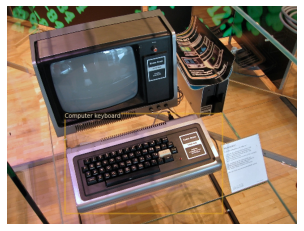

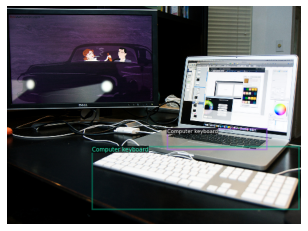

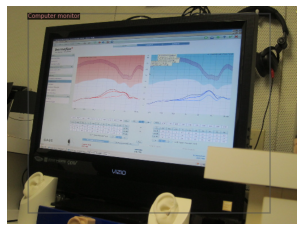

In [8]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

import matplotlib.pyplot as plt
dataset_dicts = get_balloon_dicts(train_images_dir,train_annotations_dir)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# **Train Detectron with Faster R-CNN**

In [10]:
cfg = get_cfg()
cfg.OUTPUT_DIR = '/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/valloss_output_faster-rcnn'
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR 0.00025 
cfg.SOLVER.MAX_ITER = 100    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon)


In [11]:
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm

cfg.DATASETS.VAL = ("val",)


class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.VAL
        self._loader = iter(build_detection_train_loader(self.cfg))
        
    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)
            
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)

In [13]:


# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
# trainer.resume_or_load(resume=False)
# # trainer.train()

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)
trainer.train()

[03/29 03:19:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:04, 37.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[03/29 03:20:07 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It curre

[03/29 03:20:19 d2.utils.events]:  eta: 0:00:30  iter: 19  total_loss: 1.798  loss_cls: 1.339  loss_box_reg: 0.4405  loss_rpn_cls: 0.02907  loss_rpn_loc: 0.007644  total_val_loss: 1.854  val_loss_cls: 1.315  val_loss_box_reg: 0.4604  val_loss_rpn_cls: 0.01819  val_loss_rpn_loc: 0.01146  time: 0.3721  data_time: 0.0196  lr: 4.7703e-05  max_mem: 2517M
[03/29 03:20:30 d2.utils.events]:  eta: 0:00:22  iter: 39  total_loss: 1.172  loss_cls: 0.7152  loss_box_reg: 0.362  loss_rpn_cls: 0.01862  loss_rpn_loc: 0.008605  total_val_loss: 1.224  val_loss_cls: 0.6788  val_loss_box_reg: 0.4569  val_loss_rpn_cls: 0.01227  val_loss_rpn_loc: 0.006458  time: 0.3755  data_time: 0.0103  lr: 9.7653e-05  max_mem: 2517M
[03/29 03:20:41 d2.utils.events]:  eta: 0:00:15  iter: 59  total_loss: 0.8342  loss_cls: 0.4074  loss_box_reg: 0.3818  loss_rpn_cls: 0.01286  loss_rpn_loc: 0.01118  total_val_loss: 1.03  val_loss_cls: 0.4764  val_loss_box_reg: 0.4305  val_loss_rpn_cls: 0.0165  val_loss_rpn_loc: 0.011  time: 0.

In [14]:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("val", )
predictor = DefaultPredictor(cfg)

#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

evaluator = COCOEvaluator("val", cfg, False, output_dir='/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/new_check_output_faster-rcnn')
val_loader = build_detection_test_loader(cfg, "val")
res = inference_on_dataset(trainer.model, val_loader, evaluator)


WARNING [03/29 03:22:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[03/29 03:22:16 d2.evaluation.coco_evaluation]: 'val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [03/29 03:22:16 d2.data.datasets.coco]: Using previously cached COCO format annotations at '/content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/new_check_output_faster-rcnn/val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[03/29 03:22:17 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/29 03:22:17 d2.data.common]: Serializing 54 elements to byte tensors and concatenating them all ...
[03/29 03:22:17 d2.data.common]: Serialized dataset takes 0.01 MiB
[03/29 03:22:17 d2.evaluation.evaluator]: Start infe

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[03/29 03:22:19 d2.evaluation.evaluator]: Inference done 11/54. 0.0964 s / img. ETA=0:00:04
[03/29 03:22:23 d2.evaluation.evaluator]: Total inference time: 0:00:04.920964 (0.100428 s / img per device, on 1 devices)
[03/29 03:22:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.096906 s / img per device, on 1 devices)
[03/29 03:22:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/29 03:22:23 d2.evaluation.coco_evaluation]: Saving results to /content/drive/MyDrive/UBS-Auto_Server_Audit /Detectron/new_check_output_faster-rcnn/coco_instances_results.json
[03/29 03:22:24 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[03/29 03:22:24 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[03/29 03:22:24 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.02 seconds.
[03/29 03:22:24 d2.evaluation.fast_ev

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


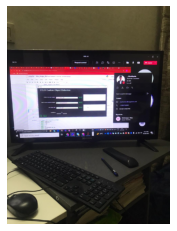

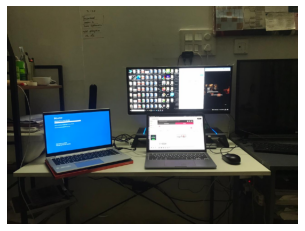

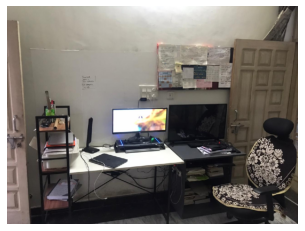

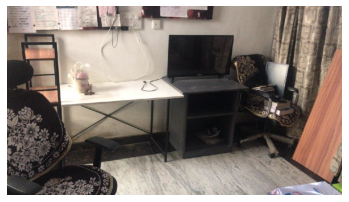

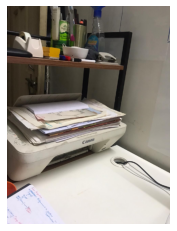

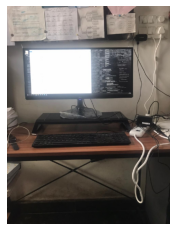

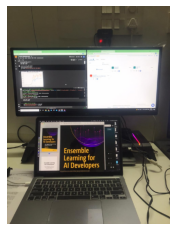

In [15]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt



#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("val", )

predictor = DefaultPredictor(cfg)


base_path = '/content/drive/MyDrive/testing/test_images/pmk_personal_testimages/'
for i in os.listdir(base_path):
  if i[-3:] == 'jpg' or 'jpeg':
    img_path = base_path + i 
    im = cv2.imread(img_path)
    outputs = predictor(im)
    # print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    cv2_imshow(v.get_image()[:, :, ::-1])